In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the training and testing data
train_path = '/content/Google_train_data.csv'
test_path = '/content/Google_test_data.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [ ]:
# Debugging: Check the data types of the columns
print("Training data types:\n", train_data.dtypes)
print("Testing data types:\n", test_data.dtypes)

Training data types:
 Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object
Testing data types:
 Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
# Preprocess the data
def preprocess_data(data):
    # Check and convert the 'Volume' and 'Close' columns to strings if they are not already
    if data['Volume'].dtype != 'object':
        data['Volume'] = data['Volume'].astype(str)
    if data['Close'].dtype != 'object':
        data['Close'] = data['Close'].astype(str)

    # Remove commas and convert to float
    data['Volume'] = data['Volume'].str.replace(',', '').astype(float)
    data['Close'] = data['Close'].str.replace(',', '').astype(float)
    data = data.drop(columns=['Date'])

    # Feature Engineering: Add moving averages
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()

    # Fill NaN values that were introduced by rolling
    data = data.fillna(0)

    return data

In [ ]:
# Apply preprocessing to the data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [ ]:
# Verify preprocessing
print("Processed training data:\n", train_data.head())
print("Processed testing data:\n", test_data.head())

Processed training data:
      Open    High     Low   Close      Volume  SMA_10  SMA_50
0  325.25  332.83  324.97  663.59   7380500.0     0.0     0.0
1  331.27  333.87  329.08  666.45   5749400.0     0.0     0.0
2  329.83  330.75  326.89  657.21   6590300.0     0.0     0.0
3  328.34  328.77  323.68  648.24   5405900.0     0.0     0.0
4  322.04  322.29  309.46  620.76  11688800.0     0.0     0.0
Processed testing data:
           Open         High          Low        Close    Adj Close     Volume  \
0  1236.979980  1249.272949  1233.640991  1235.010010  1235.010010   997300.0   
1  1235.189941  1245.869995  1225.109985  1242.099976  1242.099976  1348100.0   
2  1229.260010  1235.239990  1209.510010  1214.380005  1214.380005  1828800.0   
3  1224.729980  1226.000000  1202.550049  1206.489990  1206.489990  1343200.0   
4  1202.030029  1209.020020  1188.239990  1200.959961  1200.959961  1389600.0   

   SMA_10  SMA_50  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     0.0 

In [ ]:
# Separate features and target variable in training data
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close']

In [ ]:
# Separate features and target variable in testing data
X_test = test_data.drop(columns=['Close', 'Adj Close'])
y_test = test_data['Close']

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define the ANN model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # Adding dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/300
32/32 [==============================] - 2s 14ms/step - loss: 516806.0312 - val_loss: 512572.2188
Epoch 2/300
32/32 [==============================] - 0s 8ms/step - loss: 282826.4062 - val_loss: 53422.9648
Epoch 3/300
32/32 [==============================] - 0s 6ms/step - loss: 33086.9102 - val_loss: 35485.9492
Epoch 4/300
32/32 [==============================] - 0s 6ms/step - loss: 14651.2324 - val_loss: 5861.6997
Epoch 5/300
32/32 [==============================] - 0s 9ms/step - loss: 10769.6201 - val_loss: 5457.7153
Epoch 6/300
32/32 [==============================] - 0s 9ms/step - loss: 9109.0713 - val_loss: 3659.3521
Epoch 7/300
32/32 [==============================] - 0s 8ms/step - loss: 8513.3906 - val_loss: 4488.6152
Epoch 8/300
32/32 [==============================] - 0s 7ms/step - loss: 8011.7725 - val_loss: 2832.7378
Epoch 9/300
32/32 [==============================] - 0s 6ms/step - loss: 7651.1748 - val_loss: 2335.4094
Epoch 10/300
32/32 [=======================

In [ ]:
# Evaluate model performance
y_pred = model.predict(X_test).flatten()

8/8 [==============================] - 0s 3ms/step


In [ ]:
# Calculate custom accuracy
def custom_accuracy(y_true, y_pred):
    return np.mean(1 - np.abs((y_true - y_pred) / y_true))

accuracy = custom_accuracy(y_test.values, y_pred)
print(f'Custom Accuracy: {accuracy:.4f}')

Custom Accuracy: 0.8518


In [ ]:
# Evaluate using standard metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 168.43
Mean Squared Error (MSE): 44260.68
Root Mean Squared Error (RMSE): 210.38


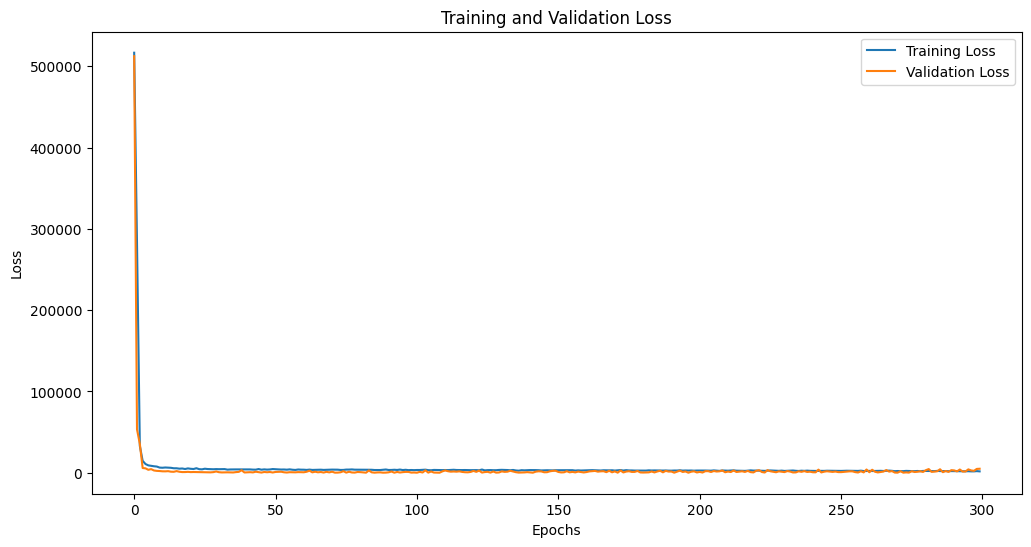

In [ ]:
# Plot training history (optional)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Function to make predictions with new input data
def predict_new(input_data):
    input_df = pd.DataFrame(input_data, index=[0])
    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)
    return prediction[0][0]

In [ ]:
# Example input data
new_input = {
    'Open': 1500,
    'High': 1520,
    'Low': 1480,
    'Volume': 1200000,
    'SMA_10': 1510,  # Example values for new features
    'SMA_50': 1490   # Example values for new features
}

In [ ]:
# Make a prediction with the new input data
predicted_close = predict_new(new_input)
print(f'Predicted Close Price: {predicted_close:.2f}')

1/1 [==============================] - 0s 28ms/step
Predicted Close Price: 1420.78
